# Data Exploration

Prerequisite: run > `python setup.py`

Explore the preprocessed data. 

Moonboard versions: 2016 ; 2017

In [21]:
import os
import numpy as np
import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# set default size to display larger figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Data exploration script

It computes:
- number of examples
- fraction of user labeled examples

It plots:
- class distributions
- holds used for easy (6B+), intermediate (7B+) and hard (8B+) problems

It describes:
- train/val/test splits

In [23]:
def class_distribution(grade2class, y_list, n_total, fig_legend, y_user_list=None):
    """Plot an histogram of the class distribution in the dataset(s)
    """    
    
    if not isinstance(y_list, list):
        y_list = [y_list]
    
    for k, subset_name in enumerate(fig_legend):
        y_filtered = y_list[k][y_list[k] != -1]
        # number of examples 
        n_examples = y_filtered.shape[0]
        print("There are {} examples in {}: {:.2f} of the whole dataset.".format(n_examples, subset_name, n_examples/n_total))
        
        if not y_user_list is None:
            y_user_filtered = y_user_list[k][y_user_list[k] != -1]
            print("Only {:.2f}% of them have a user-assigned grade".format(y_user_filtered.shape[0]/n_examples*100))

    
    # class distribution
    class_min = min(grade2class.values())
    class_max = max(grade2class.values())
    
    # plot histogram
    plt.hist(y_list, bins = range(class_min, class_max+2), density=True, histtype='bar')
    plt.legend(fig_legend)
    plt.xticks(list(grade2class.values()), list(grade2class.keys()))
    plt.xlabel("Grade")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()
    # print class distribution
    for k, subset_name in enumerate(fig_legend):
        y_filtered = y_list[k][y_list[k] != -1]
        grade2freq = {grade: round(y_filtered[y_filtered==grade2class[grade]].shape[0]/y_filtered.shape[0]*100, 1) for grade in grade2class.keys()}
        print("Distribution of classes in {} :\n{}".format(subset_name, grade2freq))

In [24]:
def data_exploration(MBversions, ppDirName="binary"):
    
    # input type cleanup to match expected type
    if not isinstance(MBversions, list):
        MBversions = [MBversions]
    
    # initialization
    X_list, X_type_list, y_list, y_user_list = [], [], [], []
        
    for MBversion in MBversions:
        MBversion = str(MBversion)
        print("{:-^100}".format("Data exploration for MoonBoard version {}".format(MBversion)))
        # path to the data
        ppVersionDirName = os.path.join(ppDirName, MBversion)
        # import the data
        X_list.append(np.load(os.path.join(ppVersionDirName, "X.npy")))
        X_type_list.append(np.load(os.path.join(ppVersionDirName, "X_type.npy")))
        y_list.append(np.load(os.path.join(ppVersionDirName, "y.npy")))
        y_user_list.append(np.load(os.path.join(ppVersionDirName, "y_user.npy")))
    
    X, X_type, y, y_user = np.vstack(X_list), np.vstack(X_type_list), np.hstack(y_list), np.hstack(y_user_list)
    
    with open(os.path.join(ppVersionDirName, "grade2class.json")) as json_file:  
        grade2class = json.load(json_file)

    # number of examples 
    n_total = y.shape[0]
    print("There are in total {} examples (distinct MoonBoard version {} problems).".format(n_total, MBversion))
        
    # class distribution
    class_distribution(grade2class, [y, y_user], n_total, ["true label", "user assigned grade"])

    # plot a heatmap of the most used holds
    grades = ["6B+", "7B+", "8B+"]
    
    fig, axn = plt.subplots(1, len(grades))
    cbar_ax = fig.add_axes([.91, .25, .03, .5])

    for i, grade in enumerate(grades):
        # filter holds based on their type: only intermediate holds are kept (as start and end holds tend to be most similar and most frequent)
        mask = X_type == 1
        X_filtered = X*mask
        # filter examples based on their label
        X_filtered = X_filtered[y == grade2class[grade],:]
        # build the heatmap
        heatmap = np.reshape(np.sum(X_filtered, axis=0), (18,11))
        freq_heatmap = heatmap / X_filtered.shape[0]
        # plot the heatmap
        ax = sns.heatmap(freq_heatmap, vmax=0.3, cmap='viridis', linewidth=0.5, square=True, 
                         xticklabels = [str(chr(k)) for k in range(ord("A"), ord("A") + heatmap.shape[1])],
                         yticklabels = range(heatmap.shape[0],0,-1),
                         mask=(freq_heatmap==0), ax=axn[i], 
                         cbar = not i, cbar_ax=None if i else cbar_ax)
        ax.set_title(grade)
    plt.show()
    
    # train/dev/test analysis
    split_names = ["Train", "Val", "Test"]
    print("{:-^100}".format("{} split analysis.".format("/".join(split_names))))
    # load data
    y_list = []
    y_user_list = []
    for split_name in split_names:
        y_list.append(np.load(os.path.join(ppVersionDirName, "y_"+ split_name + ".npy")))
        y_user_list.append(np.load(os.path.join(ppVersionDirName, "y_user_"+ split_name + ".npy")))
    # class distribution
    class_distribution(grade2class, y_list, n_total, fig_legend=split_names, y_user_list=y_user_list)

## Moonboard 2016

----------------------------Data exploration for MoonBoard version 2016-----------------------------
There are in total 27183 examples (distinct MoonBoard version 2016 problems).
There are 27183 examples in true label: 1.00 of the whole dataset.
There are 10790 examples in user assigned grade: 0.40 of the whole dataset.


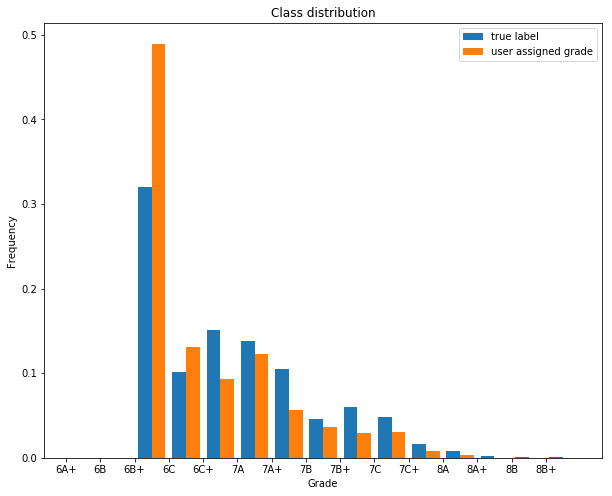

Distribution of classes in true label :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.2, '7A': 13.8, '7A+': 10.6, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.2, '8B': 0.1, '8B+': 0.1}
Distribution of classes in user assigned grade :
{'6A+': 0.0, '6B': 0.0, '6B+': 48.9, '6C': 13.1, '6C+': 9.3, '7A': 12.3, '7A+': 5.7, '7B': 3.6, '7B+': 2.9, '7C': 3.1, '7C+': 0.8, '8A': 0.3, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


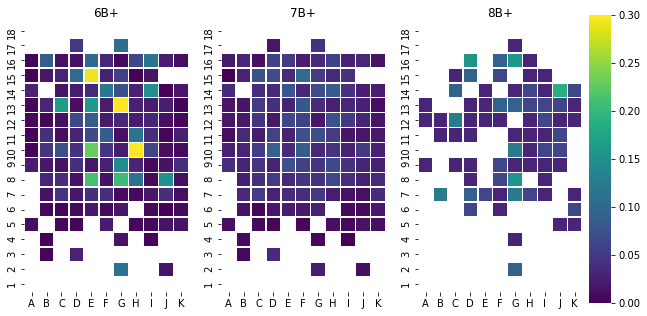

-----------------------------------Train/Val/Test split analysis.-----------------------------------
There are 21733 examples in Train: 0.80 of the whole dataset.
Only 39.64% of them have a user-assigned grade
There are 2725 examples in Val: 0.10 of the whole dataset.
Only 40.11% of them have a user-assigned grade
There are 2725 examples in Test: 0.10 of the whole dataset.
Only 39.67% of them have a user-assigned grade


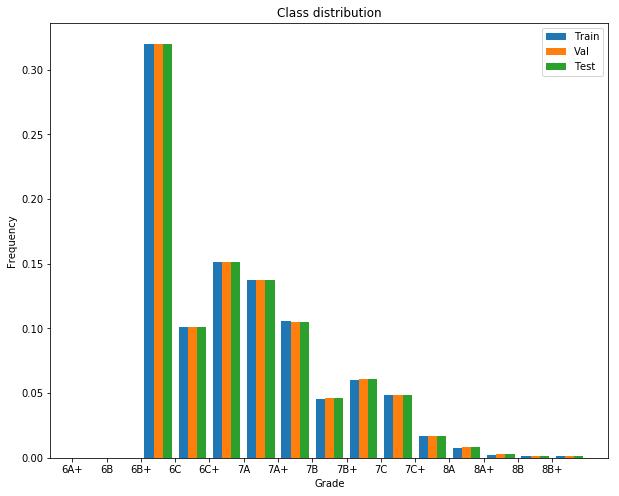

Distribution of classes in Train :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.2, '7A': 13.8, '7A+': 10.6, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.2, '8B': 0.1, '8B+': 0.1}
Distribution of classes in Val :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.1, '7A': 13.8, '7A+': 10.5, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.3, '8B': 0.1, '8B+': 0.1}
Distribution of classes in Test :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.1, '7A': 13.8, '7A+': 10.5, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.3, '8B': 0.1, '8B+': 0.1}


In [25]:
data_exploration(2016)

## Moonboard 2017

----------------------------Data exploration for MoonBoard version 2017-----------------------------
There are in total 20043 examples (distinct MoonBoard version 2017 problems).
There are 20043 examples in true label: 1.00 of the whole dataset.
There are 7304 examples in user assigned grade: 0.36 of the whole dataset.


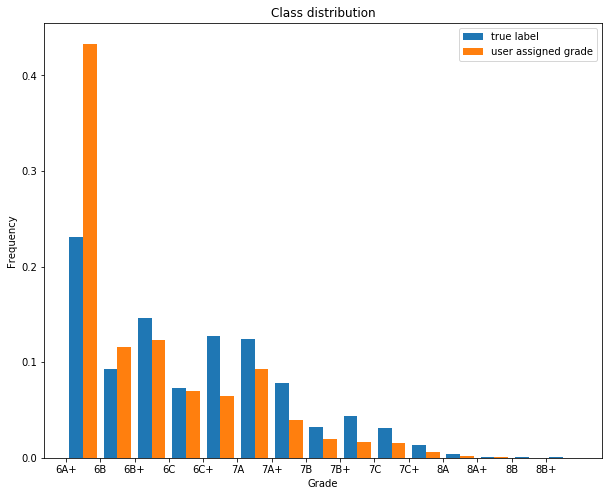

Distribution of classes in true label :
{'6A+': 23.1, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.8, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.1}
Distribution of classes in user assigned grade :
{'6A+': 43.3, '6B': 11.6, '6B+': 12.3, '6C': 7.0, '6C+': 6.5, '7A': 9.3, '7A+': 3.9, '7B': 2.0, '7B+': 1.6, '7C': 1.5, '7C+': 0.6, '8A': 0.2, '8A+': 0.1, '8B': 0.0, '8B+': 0.0}


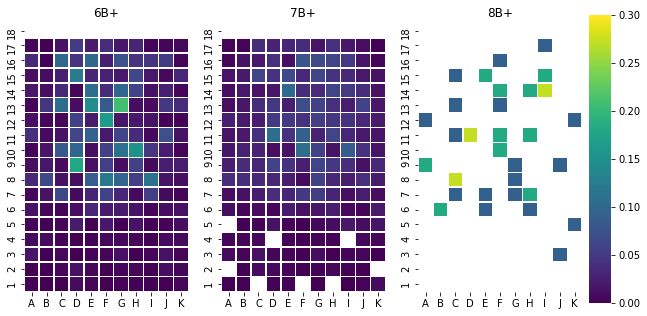

-----------------------------------Train/Val/Test split analysis.-----------------------------------
There are 16025 examples in Train: 0.80 of the whole dataset.
Only 36.33% of them have a user-assigned grade
There are 2009 examples in Val: 0.10 of the whole dataset.
Only 37.33% of them have a user-assigned grade
There are 2009 examples in Test: 0.10 of the whole dataset.
Only 36.44% of them have a user-assigned grade


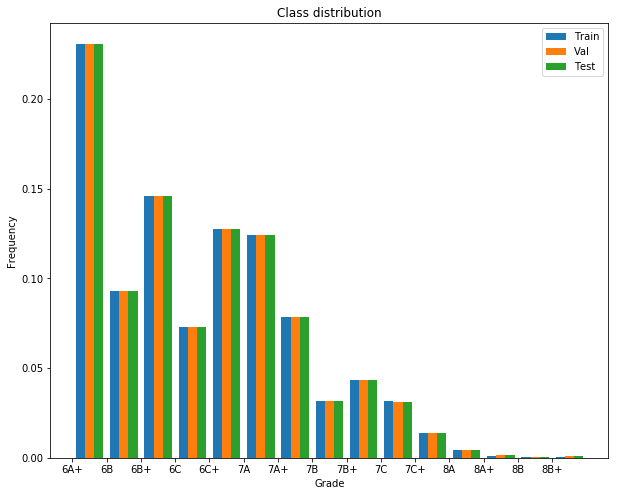

Distribution of classes in Train :
{'6A+': 23.1, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.8, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.0}
Distribution of classes in Val :
{'6A+': 23.0, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.7, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.1}
Distribution of classes in Test :
{'6A+': 23.0, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.7, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.1}


In [26]:
data_exploration(2017)

## MoonBoard 2016 + 2017

----------------------------Data exploration for MoonBoard version 2016-----------------------------
----------------------------Data exploration for MoonBoard version 2017-----------------------------
There are in total 47226 examples (distinct MoonBoard version 2017 problems).
There are 47226 examples in true label: 1.00 of the whole dataset.
There are 18094 examples in user assigned grade: 0.38 of the whole dataset.


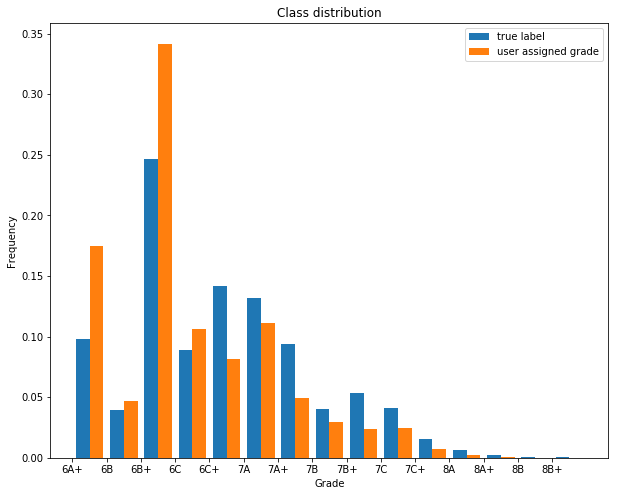

Distribution of classes in true label :
{'6A+': 9.8, '6B': 3.9, '6B+': 24.6, '6C': 8.9, '6C+': 14.1, '7A': 13.2, '7A+': 9.4, '7B': 4.0, '7B+': 5.3, '7C': 4.1, '7C+': 1.6, '8A': 0.6, '8A+': 0.2, '8B': 0.1, '8B+': 0.1}
Distribution of classes in user assigned grade :
{'6A+': 17.5, '6B': 4.7, '6B+': 34.2, '6C': 10.6, '6C+': 8.2, '7A': 11.1, '7A+': 5.0, '7B': 3.0, '7B+': 2.4, '7C': 2.5, '7C+': 0.7, '8A': 0.3, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


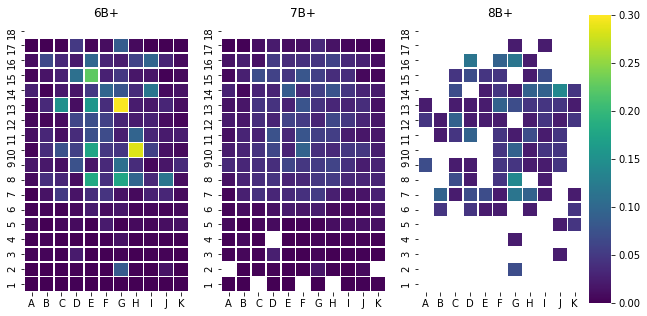

-----------------------------------Train/Val/Test split analysis.-----------------------------------
There are 16025 examples in Train: 0.34 of the whole dataset.
Only 36.33% of them have a user-assigned grade
There are 2009 examples in Val: 0.04 of the whole dataset.
Only 37.33% of them have a user-assigned grade
There are 2009 examples in Test: 0.04 of the whole dataset.
Only 36.44% of them have a user-assigned grade


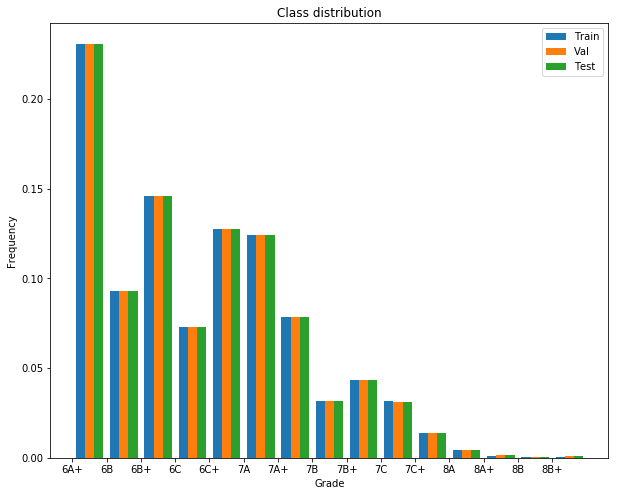

Distribution of classes in Train :
{'6A+': 23.1, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.8, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.0}
Distribution of classes in Val :
{'6A+': 23.0, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.7, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.1}
Distribution of classes in Test :
{'6A+': 23.0, '6B': 9.3, '6B+': 14.6, '6C': 7.3, '6C+': 12.7, '7A': 12.4, '7A+': 7.9, '7B': 3.2, '7B+': 4.3, '7C': 3.1, '7C+': 1.4, '8A': 0.4, '8A+': 0.1, '8B': 0.0, '8B+': 0.1}


In [27]:
data_exploration([2016, 2017])

## Size of example image

Original size of images: (C, H, W) = (3, 1000, 650)

Goal: find a good image transform to resize the image while preserving the aspect ratio. 

Operations: 
1. resize to (256, 393)
2. crop bottom (256, 384)

Remark: 384 = 3 * 2^7

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from image_preprocess import resize_wrapper

%matplotlib inline
# set default size to display larger figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# automatic reload of modules before each function execution
%reload_ext autoreload
%autoreload 2

Size of the image: (W, H) = (650, 1000). Channel mode: RGB


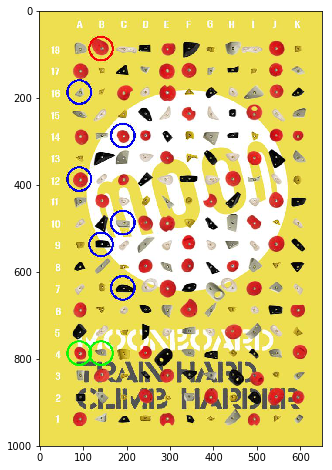

In [20]:
# development image
dev_img = Image.open('./image/2017/train/0_train_4.jpg')

print("Size of the image: (W, H) = {}. Channel mode: {}".format(dev_img.size, dev_img.mode))

# display the image
plt.imshow(np.asarray(dev_img))

Size of the image: (W, H) = (256, 393). Channel mode: RGB


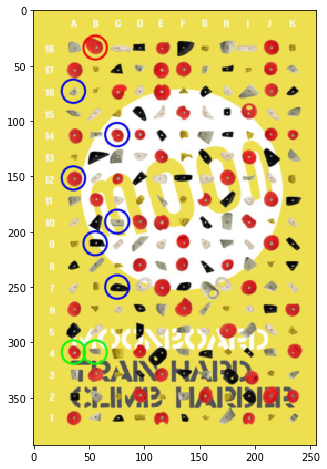

In [21]:
# resize the image
dev_img_resized = resize_wrapper(dev_img, new_height=None)

print("Size of the image: (W, H) = {}. Channel mode: {}".format(dev_img_resized.size, dev_img_resized.mode))

# display the image
plt.imshow(np.asarray(dev_img_resized))

Size of the image: (W, H) = (256, 384). Channel mode: RGB


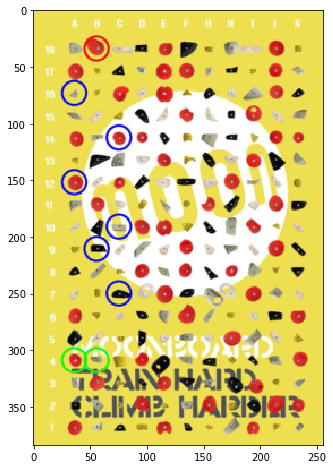

In [22]:
# crop the image
dev_img_cropped = dev_img_resized.crop(box=(0, 0, 256, 384))

print("Size of the image: (W, H) = {}. Channel mode: {}".format(dev_img_cropped.size, dev_img_cropped.mode))

# display the image
plt.imshow(np.asarray(dev_img_cropped))